# OpenGOSim

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats import norm
from scipy.stats import truncnorm, beta, uniform
import umbridge

### Inputs:

| Variable  | Dimension    | Description |
|----------|-------------|-------------|
| POROSITY|		12 | Distribution below and permeability  is derived directly from this |
| PERMZ   |		1  | PERMZ is normally a fraction of PERMX. 
|         |        | Varies between 1 to 0.01, being the most probable value 0.1.|
| FAULT  |		2  | One parameter per fault. 
|         |        | It should vary between 1 (open) to 0 (completely closed) |
| Heteorgeneity | 1 | Modify the value 0.02.
|         |        | The value can go from 0 to 1 (I would go beyond 0.25).|


|   |            |   |
|----------|:-------------:|------:|
| POROSITY RANGE:|		0.039 |	0.366  |	
| POROSITY MEAN: |		0.2	  |        |	
| POROSITY STD:  |		0.079 |        |


|   |            |
|----------|:-------------:|
| RHI = 0|		Homogeneous reservoir |
| 0.0 < RHI <0.25 |		Slightly heterogeneous reservoir	  |	
| 0.25 < RHI <0.5 |		Heterogeneous reservoir	  |	
| 0.5 < RHI <0.75 |		Very heterogeneous reservoir	  |	
| 0.75 < RHI <1.0 |		Extremely heterogeneous reservoir	  |	
| RHI = 1.0 |		Perfectly heterogeneous reservoir; unlikely this exists	  |	

Other options:
- In the file .in you can modify the aquifer permeability (How fast the aquifer can absorb pressure changes in the system)
- You could vary PERM (1 parameter) between 1 to 1000, being 1 and 1000 quite unlikely.

So we have 12 porosities, 2 faults, 1 aquifer and 1 PERMZ scaling. Totalling 16 parameters to explore.

### Input distributions:

Let $ \boldsymbol{\theta} \in \mathbb{R}^{16} $
1. Porosity $ \phi(\mathbf{x}) \sim \mathcal{N}_{[0.039, 0.366]}(\mu=0.2, \sigma=0.079) $
2. Permeability ratio (PERMZ) $\sim \text{Beta}_{[0.01, 1]}(\alpha=2, \beta=18) $
3. Fault $\sim \text{Uniform}(0, 1) $
4. Heterogeneity $ \sim \text{Beta}(\alpha=2, \beta=8) $

with joint prior distribution $  \pi(\boldsymbol{\theta})$.


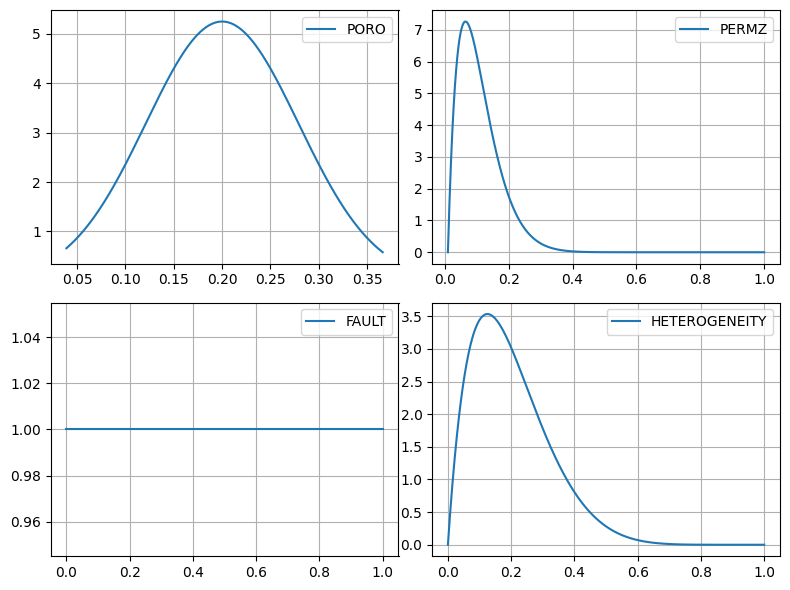

In [287]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

mu = 0.2
sigma = 0.079
lower, upper = 0.039, 0.366
a, b = (lower - mu) / sigma, (upper - mu) / sigma
x_poro = np.linspace(lower, upper, 1000)
pdf_poro = truncnorm.pdf(x_poro, a, b, loc=mu, scale=sigma) # truncated normal
axs[0].plot(x_poro, pdf_poro, label='PORO')

alpha_pz, beta_pz = 2, 18
x_permz = np.linspace(0.01, 1, 1000)
pdf_permz = beta.pdf((x_permz - 0.01) / (1 - 0.01), alpha_pz, beta_pz) / (1 - 0.01)
axs[1].plot(x_permz, pdf_permz, label='PERMZ')

x_fault = np.linspace(0, 1, 1000)
pdf_fault = uniform.pdf(x_fault)
axs[2].plot(x_fault, pdf_fault, label='FAULT')

alpha_h, beta_h = 2, 8
x_het = np.linspace(0, 1, 1000)
pdf_het = beta.pdf(x_het, alpha_h, beta_h)
axs[3].plot(x_het, pdf_het, label='HETEROGENEITY')

for i in range(4):
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### Outputs
The fields you want to analyse within the -mas.dat/CSV file are the following:
- Field fgit [m^3] : this is the accumulated CO2 injected into the model. The last value of the column is the total injected, you want to inject as much as possible.

The following fields are examples for the coarse model:
- BPressure [bar] 30_30_1
- BPressure [bar] 7_7_1
- BPressure [bar] 27_11_1

These three entries have the pressure at that precise point. You want to make sure that the pressure is not above a maximum threshold. This is 200 Bar. As the model is set up right now, the well will stop injecting if the system goes above 200 Bar so in theory this will never be triggered and the effect of reaching the maximum pressure will be that the total CO2 injected will be diminished. In any case, worth monitoring. Another option is to allow the pressure of the well to go above 200 Bar or set the threshold to be lower (say 190 Bar), up to you.


For the gas reaching the NOGO area you must check the following fields:
- BSgas 7_1_1, BSgas 7_2_1, BSgas 7_3_1,  BSgas 7_4_1, BSgas 7_5_1, BSgas 7_6_1    
- BSgas 7_7_1, BSgas 1_7_1, BSgas 2_7_1,  BSgas 3_7_1, BSgas 4_7_1, BSgas 5_7_1    
- BSgas 6_7_1, BSgas 7_7_1

These provide the saturation of gas at the top cells of the NOGO area

### More on permeability

A correlation between porosity and permeability is used to generate the permeability field using the following formula:

$perm = a b^{poro c -d}$

Potential values for constants:
1. $K = 10^{(15.6 poro - 0.9)}$
2. $K = 0.003 e^{(49 poro)}$

Note that the permeability obtained with these parameters is in mD which is not S.I. units (1 mD = 9.869233e-16 m^2). The permeability is a tensor, not a scalar. Normally, only the three diagonal components are considered and the Kx = Ky and Kz is considered to be a fraction of the others using the kv/kh ratio (vertical/horizontal permeability ratio). Thus, 

$K_z = c K_x$, where $0.01\leq c \leq 0.1$.

### Model

We want to simulate the process of CO2 injection through a porous
medium. Darcy’s Law governs the flow equation.


PFLOTRAN solves the steady-state Darcy flow equation:

$$\nabla \cdot \left( \mathbf{K}(\mathbf{x}, \boldsymbol{\theta}) \nabla p(\mathbf{x}) \right) = q(\mathbf{x})$$

where:
- $\mathbf{x} \in \Omega $: spatial domain
-  $p(\mathbf{x})$: pressure
- $\mathbf{K}(\mathbf{x}, \boldsymbol{\theta})$: uncertain permeability tensor
- $q(\mathbf{x})$: source/sink term



y=M(θ)


M is the PFLOTRAN simulation and y are quantities of interest

- Darcy: https://docs.opengosim.com/theory/mathematical_formulation_of_gw/
- Wells: https://docs.opengosim.com/theory/well_model/


## Uncertainty propagation
Goal: compute output distribution

$$\pi(\mathbf{y}) = \int_{\Theta} \delta(\mathbf{y} - \mathcal{M}(\boldsymbol{\theta})) \, \pi(\boldsymbol{\theta}) \, d\boldsymbol{\theta}$$

In [206]:
model = umbridge.HTTPModel("http://localhost:4243", "pflotran_simulation")

n_inputs = model.get_input_sizes()[0]
n_outputs = model.get_output_sizes()[0]

In [289]:
dim = n_inputs
m = 8 # number of samples 2^m
sampler = qmc.Sobol(d=dim, scramble=False)
samples = sampler.random_base2(m=m)
mean = 0.2
std = 0.079
#lower, upper = 0.039, 0.366
#a, b = (lower - mu) / sigma, (upper - mu) / sigma
#x_poro = np.linspace(lower, upper, 1000)
#pdf_poro = truncnorm.pdf(x_poro, a, b, loc=mu, scale=sigma)
samples = norm.ppf(samples)
samples = samples * std + mean
samples = samples[~np.any(samples < 0, axis=1)]
print("Number of samples: ", len(samples))
# Uniform sampling
#l_bounds = [0.039]*dim
#u_bounds = [0.366]*dim
#samples = qmc.scale(samples, l_bounds, u_bounds)

Number of samples:  243


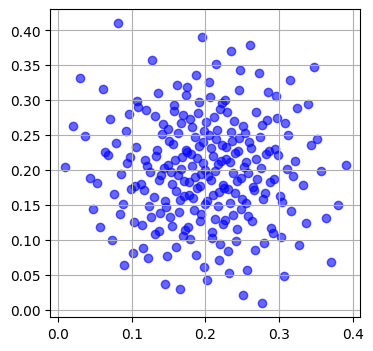

In [290]:
plt.figure(figsize=(4, 4))
plt.scatter(samples[:, 1], samples[:, 2], c='blue', alpha=0.6)
plt.grid(True)
plt.show()

In [228]:
# Quick test
print("Input: ", n_inputs)
print("Output: ", n_outputs)

sample = [list(samples[0])]
print("Sample: ", sample)
print("Model output: ", model(sample))

Input:  12
Output:  18
Sample:  [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]
Model output:  [[802578600.0, 133.7467, 131.1973, 135.2357, 0.0, 0.0235675, 0.4080922, 0.6039392, 0.6722022, 0.7145786, 0.7353182, 0.6947886, 0.6978536, 0.7043643, 0.7139079, 0.7217562, 0.7292315, 0.7353182]]


In [229]:
# Expensive bit
def evaluate_samples(samples):
    f = []
    for i in range(len(samples)):
        f.append(model([list(samples[i])]))
        print("Computed sample ", i)
    return np.array(f)
feval = evaluate_samples(samples)

mean_estimate = np.mean(feval, axis=0)
print("Mean estimate:", mean_estimate)

var_estimate = np.var(feval, axis=0)
print("Variance estimate:", var_estimate)

Mean estimate: [[8.01412041e+08 1.33693714e+02 1.31281380e+02 1.35172781e+02
  3.35781501e-01 3.51447995e-01 3.73760088e-01 3.95508464e-01
  4.17266447e-01 4.40802941e-01 4.67695068e-01 4.09332120e-01
  4.11908723e-01 4.16804201e-01 4.23630614e-01 4.32823590e-01
  4.49163968e-01 4.67695068e-01]]
Variance estimate: [[6.54401640e+12 2.10247358e-02 1.25991408e-01 1.95117656e-02
  1.34196982e-01 1.33075760e-01 1.30804068e-01 1.30284452e-01
  1.28790777e-01 1.24835498e-01 1.19348253e-01 1.32314279e-01
  1.31992324e-01 1.31439415e-01 1.30936868e-01 1.28859147e-01
  1.24002833e-01 1.19348253e-01]]


In [271]:
# Check if any pressure exceeds 200bar
output_pressure = [feval[i, 0, 1:4] for i in range(len(samples))]
#print(output_pressure)
for f in output_pressure:
    if np.any([px >= 200 for px in f]):
            print("Sample ", f, "exceeds 200 bar")

In [288]:
# Check gas in NOGO area
output_gas = [feval[i, 0, 4:-1] for i in range(len(samples))]
#print(output_gas)

s = 0
for (it,f) in enumerate(output_gas):
    if np.sum([px for px in f]) > 1.0:
        print("Sample ", it, " has ", sum([px for px in f]) , " gas in NOGO area")
        s = s+1
print("Number of samples with gas ", s)

Sample  0  has  7.419599999999999  gas in NOGO area
Sample  2  has  9.750129200000002  gas in NOGO area
Sample  3  has  9.750003699999999  gas in NOGO area
Sample  6  has  9.7502987  gas in NOGO area
Sample  7  has  9.750223400000001  gas in NOGO area
Sample  10  has  9.201842300000001  gas in NOGO area
Sample  11  has  9.7501744  gas in NOGO area
Sample  13  has  5.3639828000000005  gas in NOGO area
Sample  14  has  9.7503747  gas in NOGO area
Sample  15  has  9.750344400000001  gas in NOGO area
Sample  18  has  9.749975899999999  gas in NOGO area
Sample  19  has  9.4339867  gas in NOGO area
Sample  22  has  9.7501697  gas in NOGO area
Sample  23  has  9.7502844  gas in NOGO area
Sample  26  has  9.7476513  gas in NOGO area
Sample  27  has  9.750190899999998  gas in NOGO area
Sample  29  has  6.5461778  gas in NOGO area
Sample  30  has  9.7505489  gas in NOGO area
Sample  31  has  9.7504816  gas in NOGO area
Sample  32  has  5.05382299  gas in NOGO area
Sample  34  has  9.750109799999

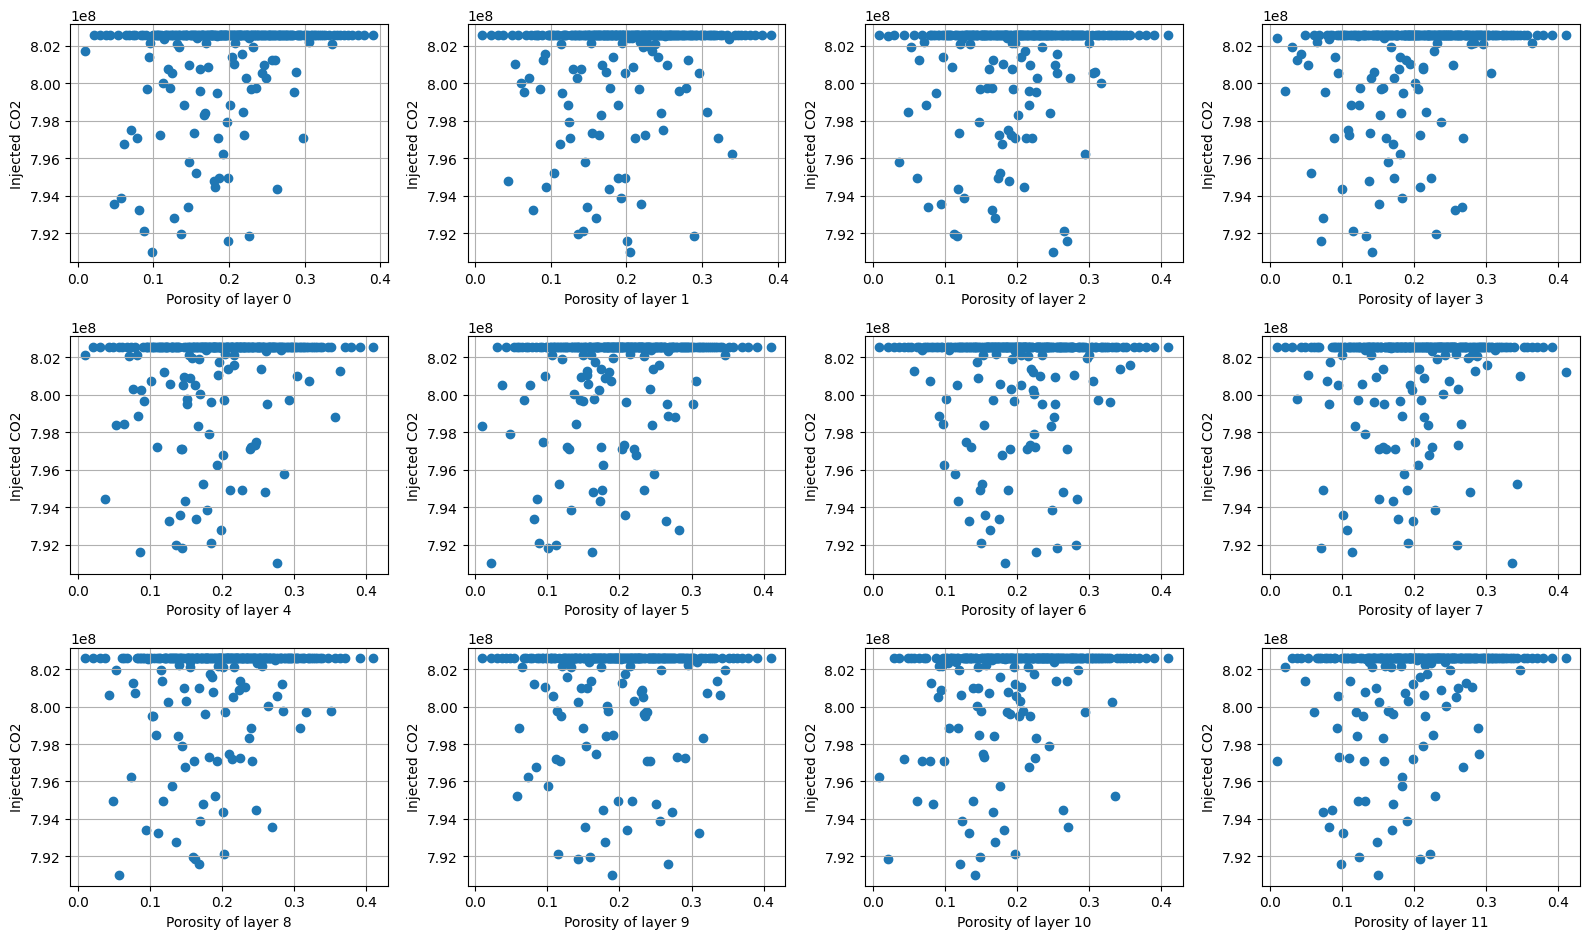

In [231]:
output0 = [feval[i, 0, 0] for i in range(len(samples))]

fig, axs = plt.subplots(3, 4, figsize=(16, 10))
for j in range(n_inputs):
    row, col = divmod(j, 4)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output0)
    ax.set_xlabel(f'Porosity of layer {j+1}')
    ax.set_ylabel('Injected CO2')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(8, 4))
for j in range(n_inputs):
    row, col = divmod(j, 4)
    ax = axs[row, col]
    ax.scatter(samples[:, j], output0)
    ax.set_xlabel(f'Porosity of layer {j+1}')
    ax.set_ylabel('Injected CO2')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

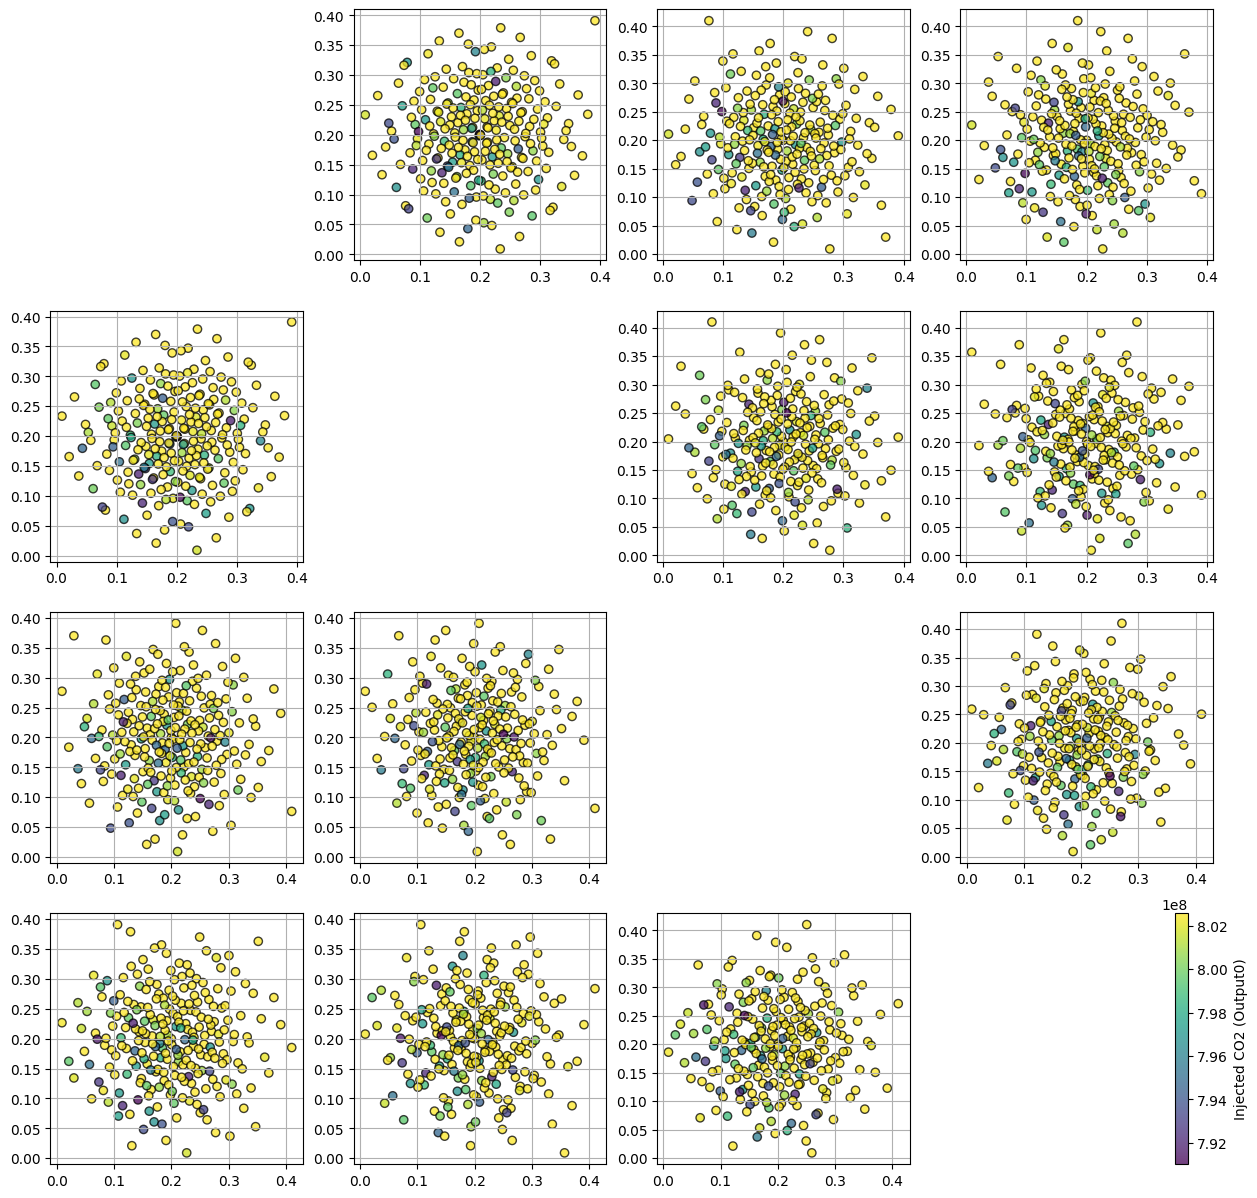

In [236]:
from scipy.interpolate import griddata 

n_plot = 4
fig, axs = plt.subplots(n_plot, n_plot, figsize=(15, 15))

for i in range(n_plot):
    for j in range(n_plot):
        ax = axs[i, j]
        if i == j:
            ax.set_visible(False)
        else:
            x = samples[:, i]
            y = samples[:, j]
            scatter = ax.scatter(x, y, c=output0, cmap='viridis', edgecolors='k', alpha=0.75)
            ax.grid(True)
        if i == n_plot - 1 and j == n_plot - 1:
            fig.colorbar(scatter, ax=ax, label='Injected CO2 (Output0)')
plt.show()

In [233]:
print(feval)

[[[8.025786e+08 1.337467e+02 1.311973e+02 ... 7.217562e-01 7.292315e-01
   7.353182e-01]]

 [[8.025786e+08 1.336198e+02 1.310284e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[8.009807e+08 1.338373e+02 1.315248e+02 ... 7.500101e-01 7.500102e-01
   7.500105e-01]]

 ...

 [[7.957764e+08 1.338844e+02 1.315837e+02 ... 7.500171e-01 7.500171e-01
   7.500173e-01]]

 [[8.025786e+08 1.334599e+02 1.308699e+02 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]

 [[8.025786e+08 1.338073e+02 1.312609e+02 ... 7.291558e-01 7.346870e-01
   7.392361e-01]]]


In [291]:
272*272

73984

In [ ]:
w